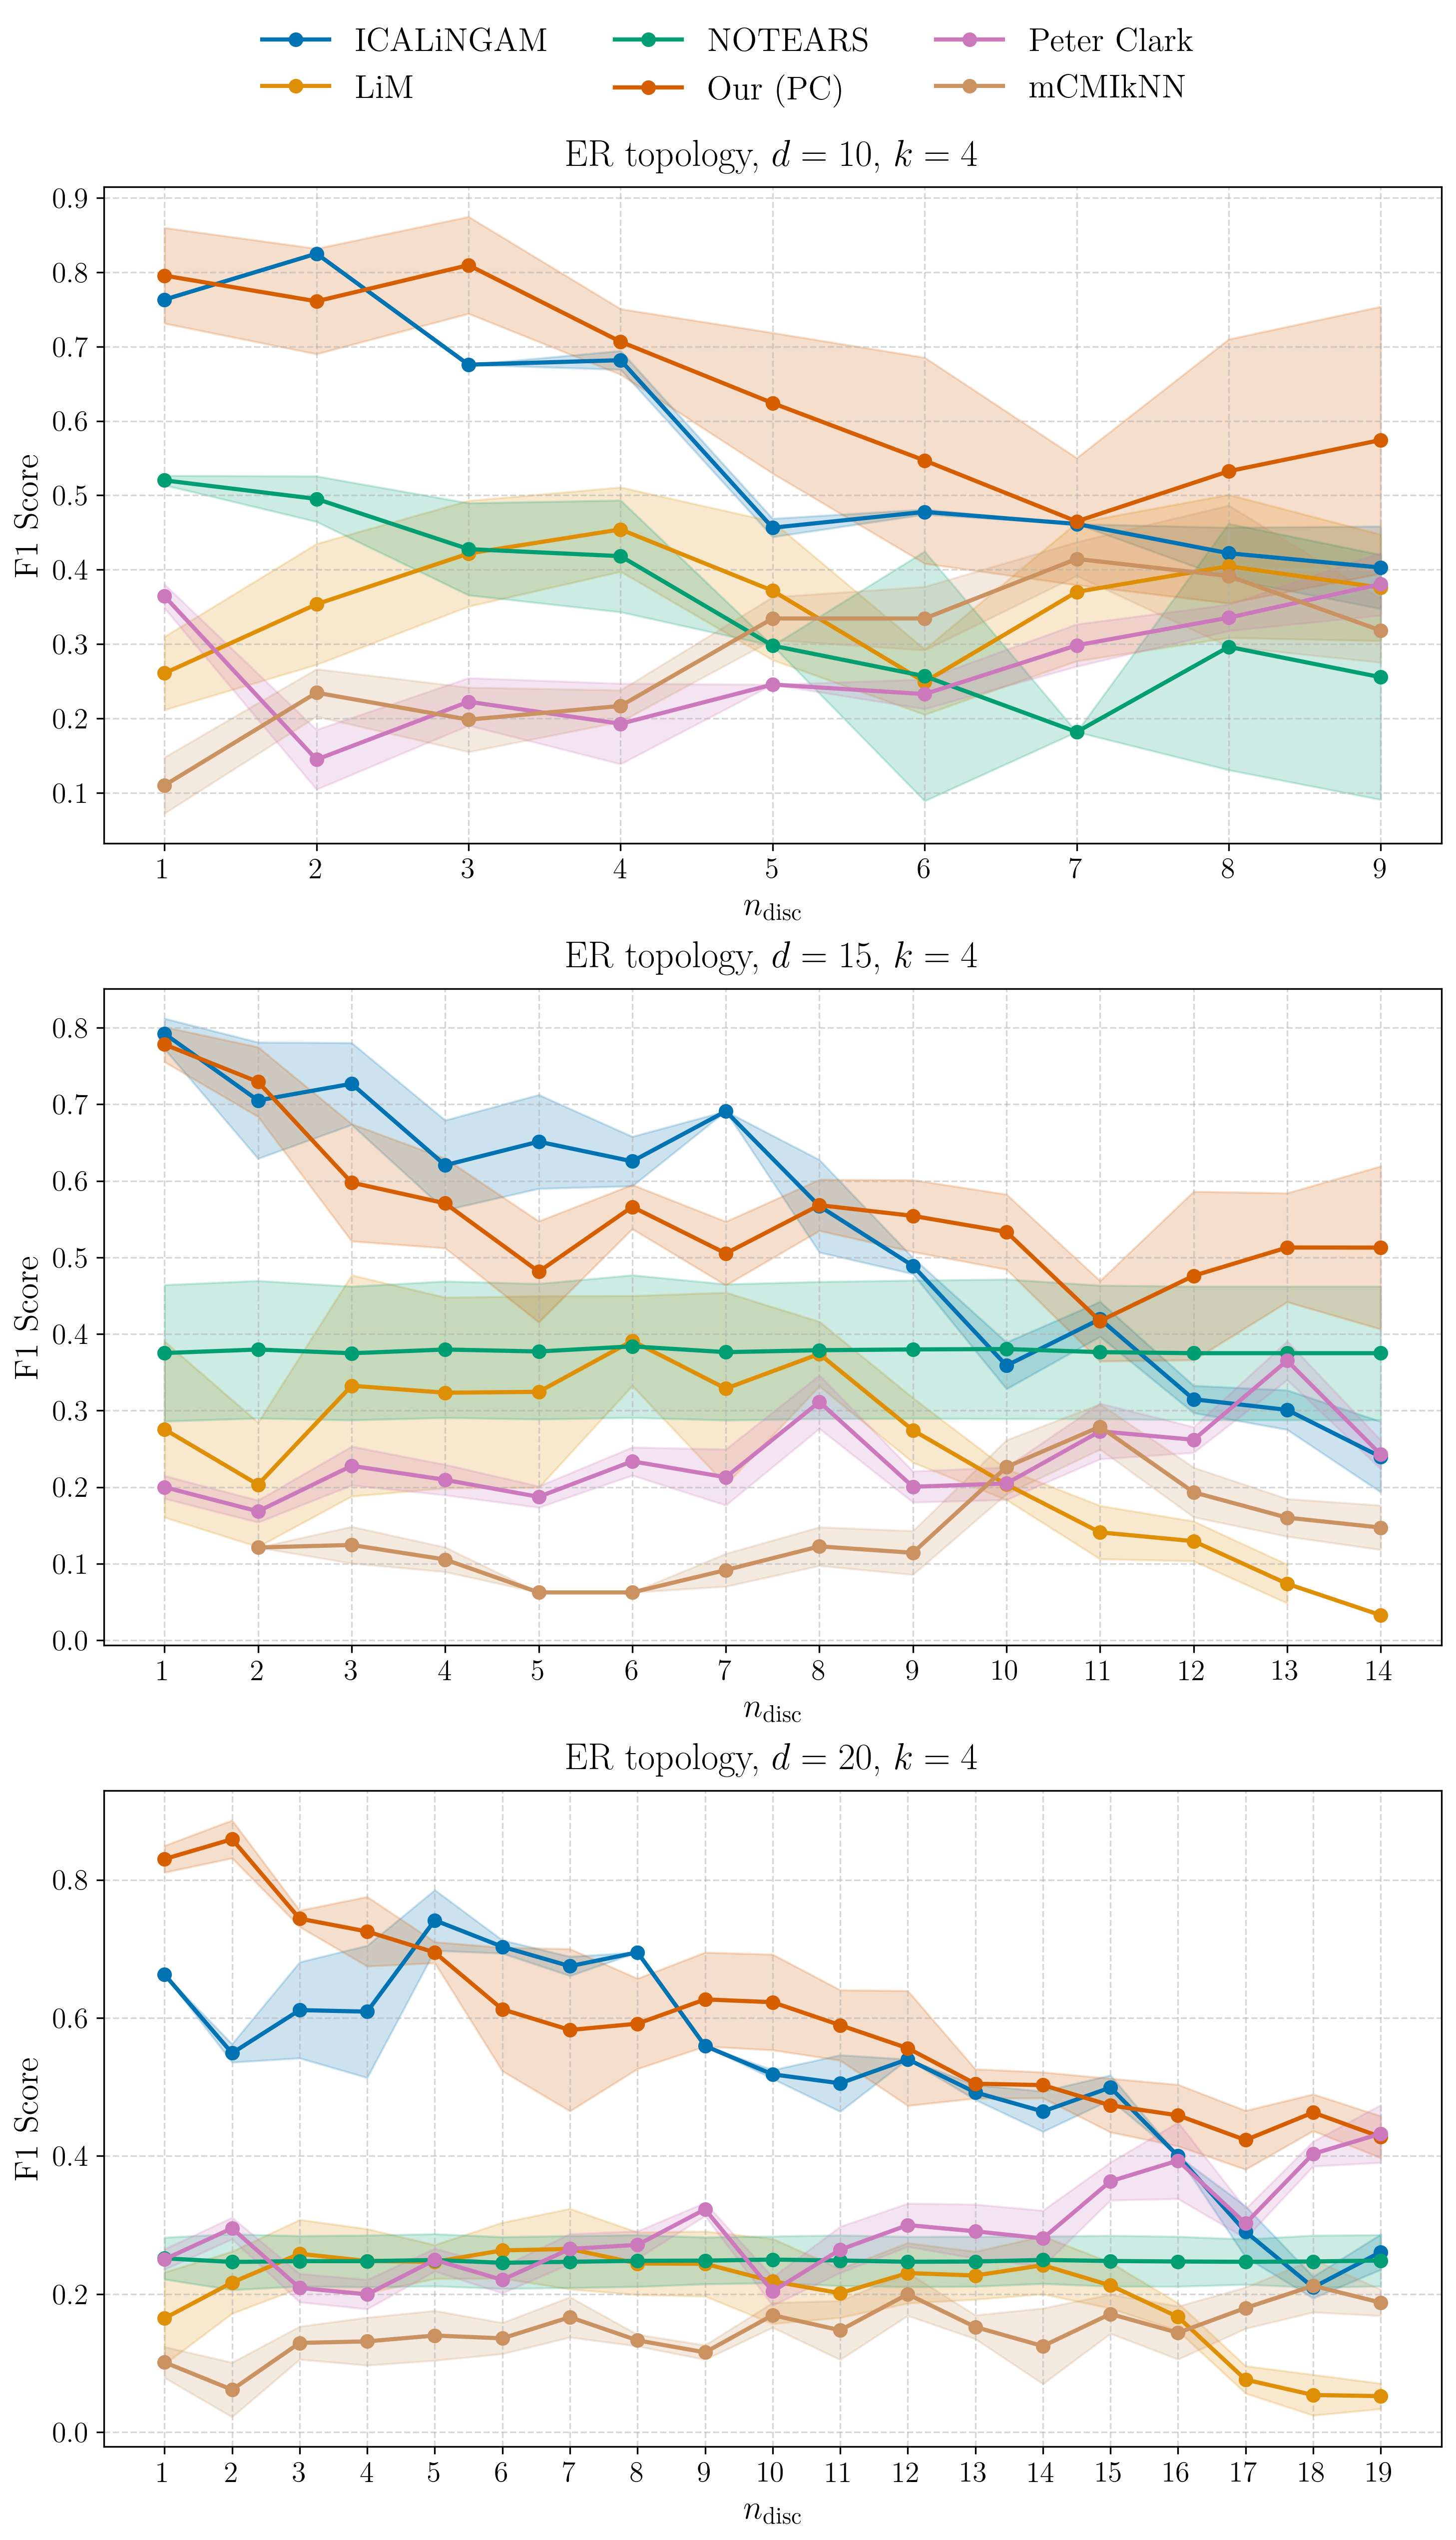

In [23]:
import os
import re
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Parameters and Paths ===
base_path = '/share/amine.mcharrak/mixed_data_final'
experiment_paths = [
    '/15ER60_linear_mixed_seed_1/experiment_results', 
    '/20ER80_linear_mixed_seed_1/experiment_results',
    '/20SF80_linear_mixed_seed_1/experiment_results',
    '/15SF60_linear_mixed_seed_1/experiment_results',
    '/15WS60_linear_mixed_seed_1/experiment_results',
    '/10ER40_linear_mixed_seed_1/experiment_results',
    '/10SF40_linear_mixed_seed_1/experiment_results',
    '/20WS80_linear_mixed_seed_1/experiment_results',
    '/10WS40_linear_mixed_seed_1/experiment_results',
]

# Select graph type: "SF", "ER", or "WS"
graph_type = "ER"
#graph_type = "SF"
#graph_type = "WS"

# === Filter and Group Experiment Folders by d (number of nodes) ===
selected_experiments = {}
for p in experiment_paths:
    if graph_type in p:
        full_path = os.path.join(base_path, p.lstrip('/'))
        # Extract d using regex.
        m = re.search(r'/(\d+)' + graph_type + r'\d+_linear_mixed_seed_1/experiment_results', full_path)
        if m:
            d_val = int(m.group(1))
            selected_experiments[d_val] = full_path

# Sort by d (e.g., d=10,15,20).
ds = sorted(selected_experiments.keys())

# === Read JSON files and Collect F1_Score Data ===
records = []
for d_val in ds:
    exp_path = selected_experiments[d_val]
    json_files = [f for f in os.listdir(exp_path) if f.endswith(".json")]
    for jf in json_files:
        jf_path = os.path.join(exp_path, jf)
        with open(jf_path, 'r') as f:
            data = json.load(f)
        for entry in data:
            seed = entry.get("seed")
            # Parse n_disc value (e.g. "n_disc_1" -> 1).
            n_disc_str = entry.get("n_disc")
            if n_disc_str is None:
                continue
            m_nd = re.search(r'n_disc_(\d+)', n_disc_str)
            if not m_nd:
                continue
            n_disc_val = int(m_nd.group(1))

            # Get F1_Score dictionary.
            f1_dict = entry.get("F1_Score")
            if f1_dict is None:
                continue
            for method, value in f1_dict.items():
                if value is None:
                    continue
                try:
                    val = float(value)
                except Exception:
                    continue
                records.append({
                    "d": d_val,
                    "n_disc": n_disc_val,
                    "seed": seed,
                    "method": method,
                    "value": val
                })

df = pd.DataFrame(records)
if df.empty:
    raise ValueError("No F1_Score data found.")

# === Plotting Settings for Publication Quality ===
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16,
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "legend.fontsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "figure.dpi": 300,
})

# Create a vertical figure (one subplot per d value).
fig, axes = plt.subplots(len(ds), 1, figsize=(10, 6 * len(ds)))
if len(ds) == 1:
    axes = [axes]

# Use a colorblind-friendly palette for methods.
methods_unique = sorted(df["method"].unique())
color_palette = sns.color_palette("colorblind", n_colors=len(methods_unique))

# Plot for each d.
for ax, d_val in zip(axes, ds):
    df_d = df[df["d"] == d_val]

    # Parse the experiment path to get the second number (for k).
    exp_path = selected_experiments[d_val]
    m_top = re.search(r'/(\d+)' + graph_type + r'(\d+)_linear_mixed_seed_1/experiment_results', exp_path)
    if m_top:
        d_parsed = int(m_top.group(1))
        top_val = int(m_top.group(2))
        k_val = top_val / d_parsed
        title_str = f"{graph_type} topology, $d={d_parsed}$, $k={k_val:.0f}$"
    else:
        title_str = f"{graph_type} topology, $d={d_val}$"

    # Plot each method: mean ± std for F1_Score over n_disc.
    for method, color in zip(methods_unique, color_palette):
        df_method = df_d[df_d["method"] == method]
        if df_method.empty:
            continue
        grp = df_method.groupby("n_disc")["value"]
        means = grp.mean()
        stds = grp.std()

        ax.plot(means.index, means.values, label=method,
                marker='o', linestyle='-', linewidth=2,
                markersize=6, color=color)
        ax.fill_between(means.index, means - stds, means + stds,
                        color=color, alpha=0.2)

    # Force integer x-ticks matching the n_disc values.
    unique_n_disc_vals = sorted(df_d["n_disc"].unique())
    ax.set_xticks(unique_n_disc_vals)
    ax.set_xticklabels(unique_n_disc_vals)

    ax.set_xlabel(r"$n_{\rm disc}$")
    ax.set_ylabel("F1 Score")
    ax.set_title(title_str, pad=10)
    ax.grid(True, linestyle="--", alpha=0.5)

# Compute number of columns for the legend (break into 2 rows).
ncol = math.ceil(len(methods_unique) / 2)

# Place the legend above the top subplot.
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc="upper center",
           bbox_to_anchor=(0.5, 0.95),
           ncol=ncol,
           frameon=False)

# Tighten layout and reduce top space so legend is closer.
fig.tight_layout()
fig.subplots_adjust(top=0.88)

# === Save the Plot ===
output_dir = os.path.expanduser("~/pcax/examples/mixed_data_plots_and_tables")
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, f"plot_increase_ndisc_F1_{graph_type}.pdf")
fig.savefig(output_file, format="pdf", bbox_inches="tight")
plt.show()
